#### Anmol Maini 

# Final Project

## Abstract

It was hypotheized that Warren Buffet's claim: "Over a ten-year period commencing on January 1, 2008, and ending on December 31, 2017, the S&P 500 will outperform a portfolio of funds of hedge funds, when performance is measured on a basis net of fees, costs and expenses." is incorrect.

I will be simulating a portfolio of funds by trading stocks based on their operating margins and revenue growth, and hence by trading a large number of companies the risk per company is reduced. Similarly a fund of hedge funds is an investment into several hedge funds which in turn use several startegies to trade in the market. My basis of using operating margins, revenue growth and both shorting and longing stocks help simulate my portfolio as a hedge fund.

By using the quantopian platform, I will be simulating my algorithm between the 1st of January 2008 and 1st of June 2017 to see how I perform against the S&P 500 to see whether I prove or contradict my hypothesis


## Introduction

### Background

The idea behind algorithmic trading is not new, and human traders have been using machine assisted platforms to trade since the 1980s. However, it has only gained popularity in the last two decades. However, a high percentage of these automated trades are used by pension and retirement funds to balance their portfolios between index funds. The other side of algorithmic trading comes under High Frequency Trading (HFT) where algorithms leverage high speed, high orders per trade, and high frequency market data to make decisions. According to a Congressional Research Paper published in 2016, HFT accounts for 55% of the trading volume in US equity markets.

In the United States(2013), there are about 17 million households with brokerage accounts, with 65% of the accounts making between 0-3 trades, 18% trading at least once a month, and only 4% executing 100 trades in the preceding year. Meanwhile, Wall Street only employes 51,600 people in 2014. Now accoring to Warren Buffet's claims, "If Group A (active investors)and Group B (do-nothing investors) comprise the total investing universe, and B is destined to achieve average results before costs, so, too, must A. Whichever group has the lower costs will win." 

But this is clearly not the case because:
1) Cost for executing trades for the general public have been falling significantly, with some platforms like Robinhood allowing trades without any charges.
2) People in Wall Street would be out of jobs if anybody (do-nothing invetsors) could just trade as good as them.

Now coming to the data, Quantopian provides certain data about all publically trades companies free of charge which comes from the companies' public filings.

Hedge Funds: Hedge funds are a partnership of investors who come up with investing strategies to make money whether the market is going up or down. These funds usually short or long stocks based on certain criterias. And a Fund of Hedge Funds is a portofolio of several hedge funds which short and long different stocks based on their individual criteria.

Simulation: My hypothesis is based upon the simulation of this funds of hedge funds. And while I am not necessarily dictating different selection critera for stocks, I have a broad criteria for shorting and longing stocks (Revenue Growth & Operating Margins), which are two signigificant metrics in the financial industry.

### Reason

If there is so much data available to traders who do this for a living, there must definitely be ways for them to leverage this data to make better decisions and hence better profits than investors who really do not have a deep understanding of the market.

### Hypothesis

It was hypothesized that Warren Buffet's claims of "Over a ten-year period commencing on January 1, 2008, and ending on December 31, 2017, the S&P 500 will outperform a portfolio of funds of hedge funds, when performance is measured on a basis net of fees, costs and expenses." and"If Group A (active investors)and Group B (do-nothing investors) comprise the total investing universe, and B is destined to achieve average results before costs, so, too, must A. Whichever group has the lower costs will win." are false.

The justification behind this hypothesis include that these investors trade for a profession so they would be able to leverage the huge amounts of data available to them to beat the market, and in turn the average investor as I am leveraging these data points while rebalancing my portfolio.

## Data and Methods

### Data Source

The source of the data is from Quantopian platform, which in turn get their data from public filings of companies listed on the Stock Exchanges. Firstly we get all the stocks in the Q1500US Data Source, which is the deafult universe of 1500 tradable stocks on the Stock Exchange. Then we also factor in companies that have a valid revenue growth and operation margin through the Moringstar Data Source and out final universe only includes stocks that are tradable, have a latest revenue growth value, and a latest operations margin value.

The values in the data that we care about are:
* Stock Ticker - uniquely identifies the company(stock): It is a textual, obsevational data point.
* Operation Margin - margin ratio of the companies'(stock) efficiency: It is a real-valued, observational data point
* Revenue Growth - growt % of the revenue that the company(stock) makes: It is a real-valued, observational data point
* Short - whether the company(stock) should be shorted: It is a boolean, interventional data point based upon the operation margin and revenue growth
* Long - whether the company(stock) should be longed: It is a boolean, interventional data point based upon the operation margin and revenue growth

### Data Cleaning

In the trading algorithm, we are making trades on a monthly basis. Although the data we get is on a quarterly basis, it wouldn't be unwise to assume that some fund managers make decisions in a shorter time frame. Every month, 3 days into the month, and 1 hour into the opening of the market, the portfolio is rebalanced. First the universe is calculated from the 1500 tradable stocks, which have a non null revenue growth and operating margin. Then they are split into two quantiles (longs, shorts). Then the algorithm makes the trades depending on the current portfolio and the rebalanced portfolio, where new stocks are shorted and longed and existing stocks are sold to clear up the necessary capital.

Note: I also made the decision to not short stocks as often as longing stocks. In the long-term, the market tends to grow so having a 50-50 split would be detrimental. I adopted a more conservative 85:15 split where I am still longing a significant amount of my capital but also making some short bets.

In [32]:
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.morningstar import operation_ratios
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
import alphalens

In [36]:
def make_pipeline():
    # Note : operation_ratios.revenue_growth, operation_ratios.operation_margin, sentiment YES
    testing_factor1 = operation_ratios.revenue_growth.latest
    testing_factor2 = operation_ratios.operation_margin.latest
    
    universe = ( Q1500US() & testing_factor1.notnull() &    
                testing_factor2.notnull() 
               )
    
    testing_factor1 = testing_factor1.rank(mask=universe, method='average')
    testing_factor2 = testing_factor2.rank(mask=universe, method='average')
    
    testing_factor = testing_factor1 + testing_factor2
    testing_quantiles = testing_factor.quantiles(2)
    
    pipe = Pipeline(columns={'testing_factor': testing_factor,
                             'shorts': testing_quantiles.eq(0),
                             'longs' : testing_quantiles.eq(1)},
                             screen=universe)
    return pipe

In [37]:
res = run_pipeline(make_pipeline(), start_date='2008-01-01', end_date='2008-02-01')

In [38]:
res.head()

longs shorts  testing_factor
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])   False   True           355.0
                          Equity(24 [AAPL])   True  False          2101.0
                          Equity(62 [ABT])    True  False          1689.0
                          Equity(67 [ADSK])   True  False          1991.0
                          Equity(76 [TAP])   False   True          1139.0

### Explanation

So what we see from creating this pipeline and doing the analysis is that some of these stocks should be longed (on the 2nd of January 2008), while others should be shorted based on the last quarter's financial results of these stocks. Note this is just a sample of the stocks in the result. The actual size of the results is:

In [39]:
assets = res.index.levels[1].unique() # Unique companies(stocks)
len(assets)

1510

Moreover, not all these stocks are longed or shorted. We are both limited by the amount of capital that can be used to make these trades, and the time in a trading day. Note, while the trades might seem instantaneous they do make some time to execute. And if one is executing a million or billion different trades, it might not be possible.

In [40]:
pricing = get_pricing(assets, start_date='2007-12-01', end_date='2008-03-01', fields='open_price')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated and will be removed in the future. Please use the new API instead.
  after removing the cwd from sys.path.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,7.0,1496.0,969.945585,385.772517,16227,50.037003
2,1479.0,2931.0,1983.609702,377.060410,16203,49.962997


Returns Analysis


,1,5,10
Ann. alpha,-0.211,-0.270,-0.269
beta,-0.009,-0.008,-0.012
Mean Period Wise Return Top Quantile (bps),-6.369,-42.787,-86.645
Mean Period Wise Return Bottom Quantile (bps),6.359,42.723,86.517
Mean Period Wise Spread (bps),-12.782,-17.131,-17.335


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/pl

Information Analysis


,1,5,10
IC Mean,-0.015,-0.059,-0.083
IC Std.,0.090,0.084,0.072
t-stat(IC),-0.805,-3.298,-5.396
p-value(IC),0.430,0.003,0.000
IC Skew,0.102,-0.100,0.771
IC Kurtosis,-0.446,-0.731,-0.200
Ann. IR,-2.723,-11.163,-18.263


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.002,0.005,0.01
Quantile 2 Mean Turnover,0.001,0.005,0.01


,1,5,10
Mean Factor Rank Autocorrelation,1.0,0.998,0.995


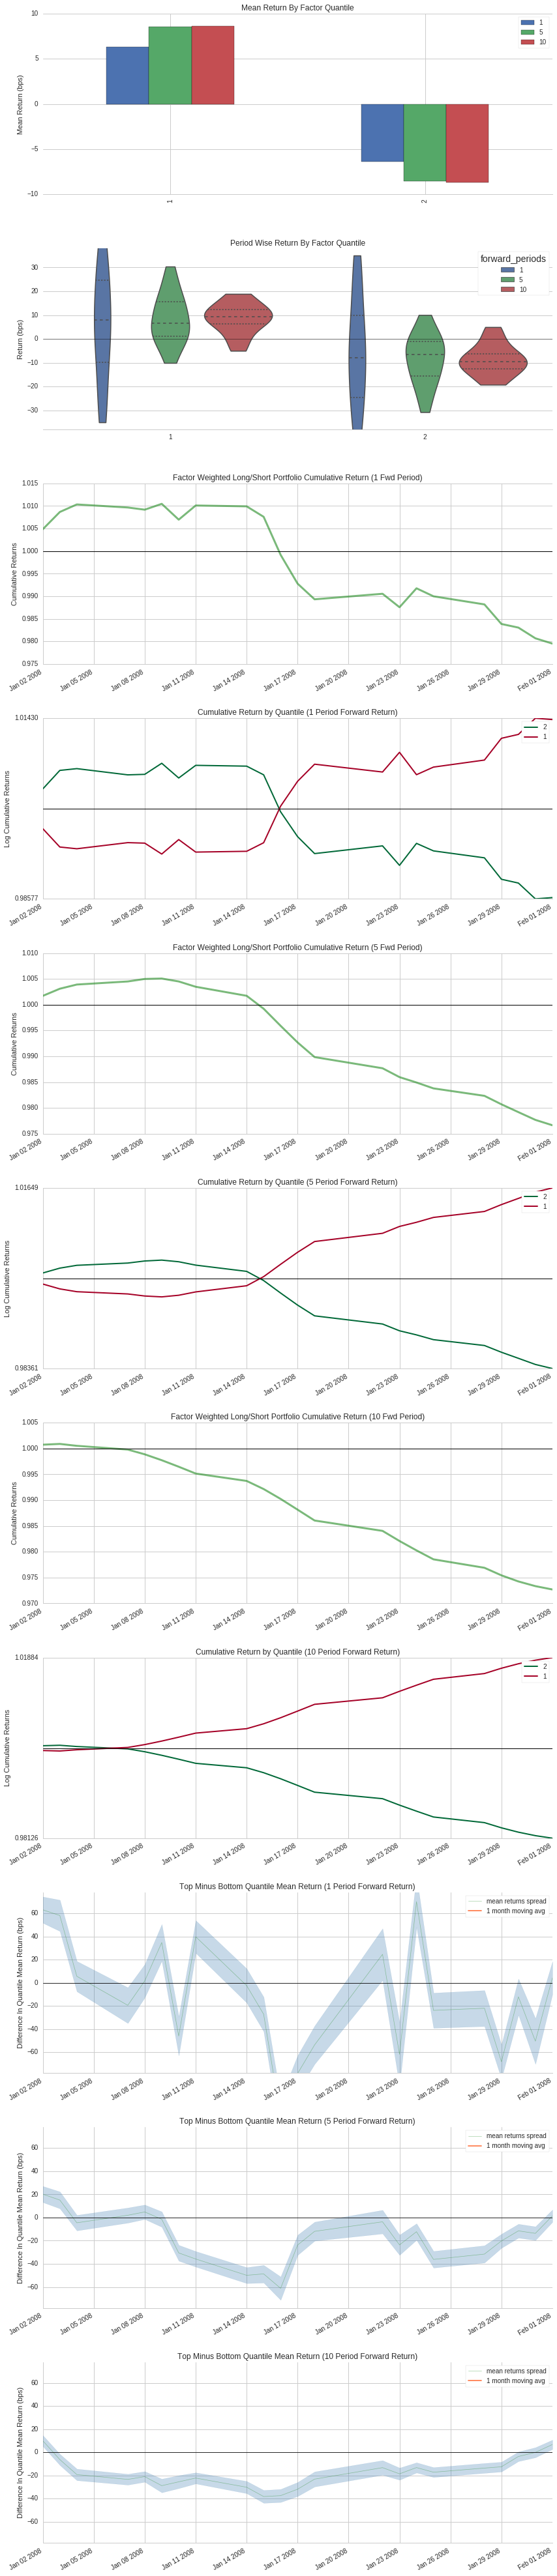

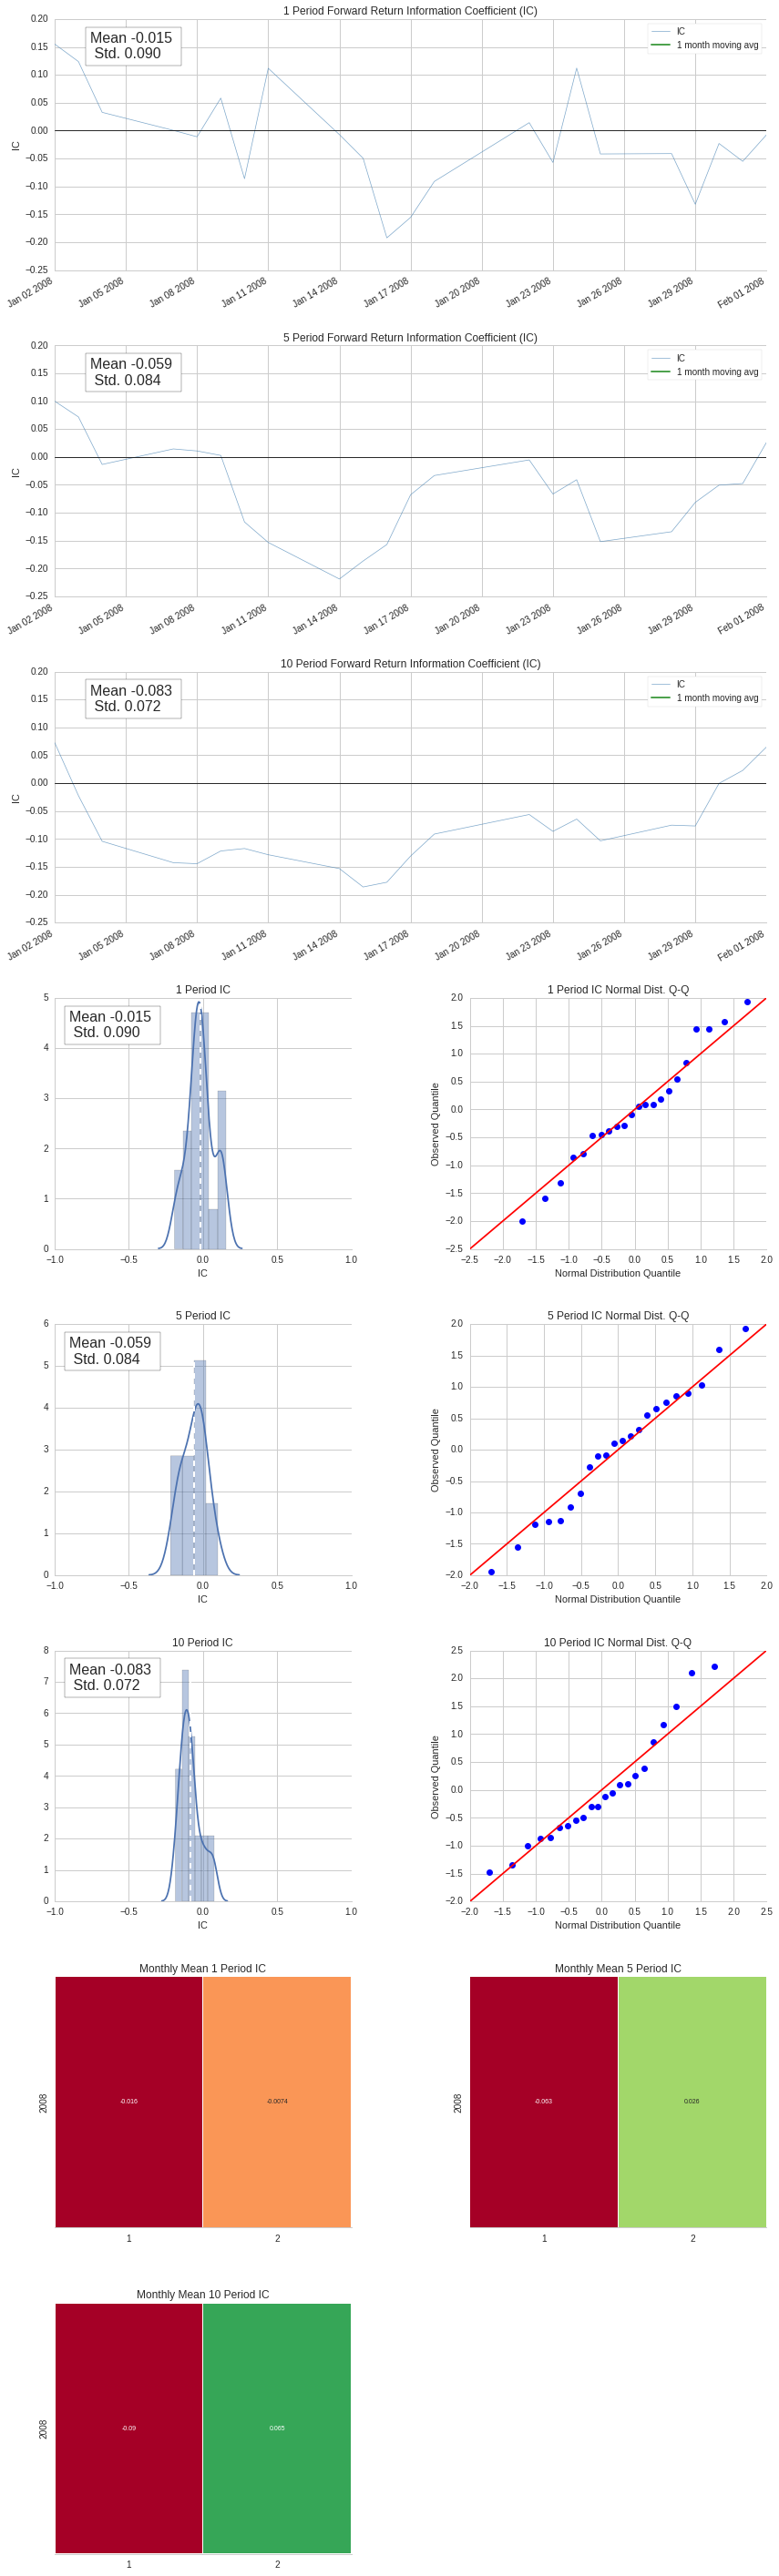

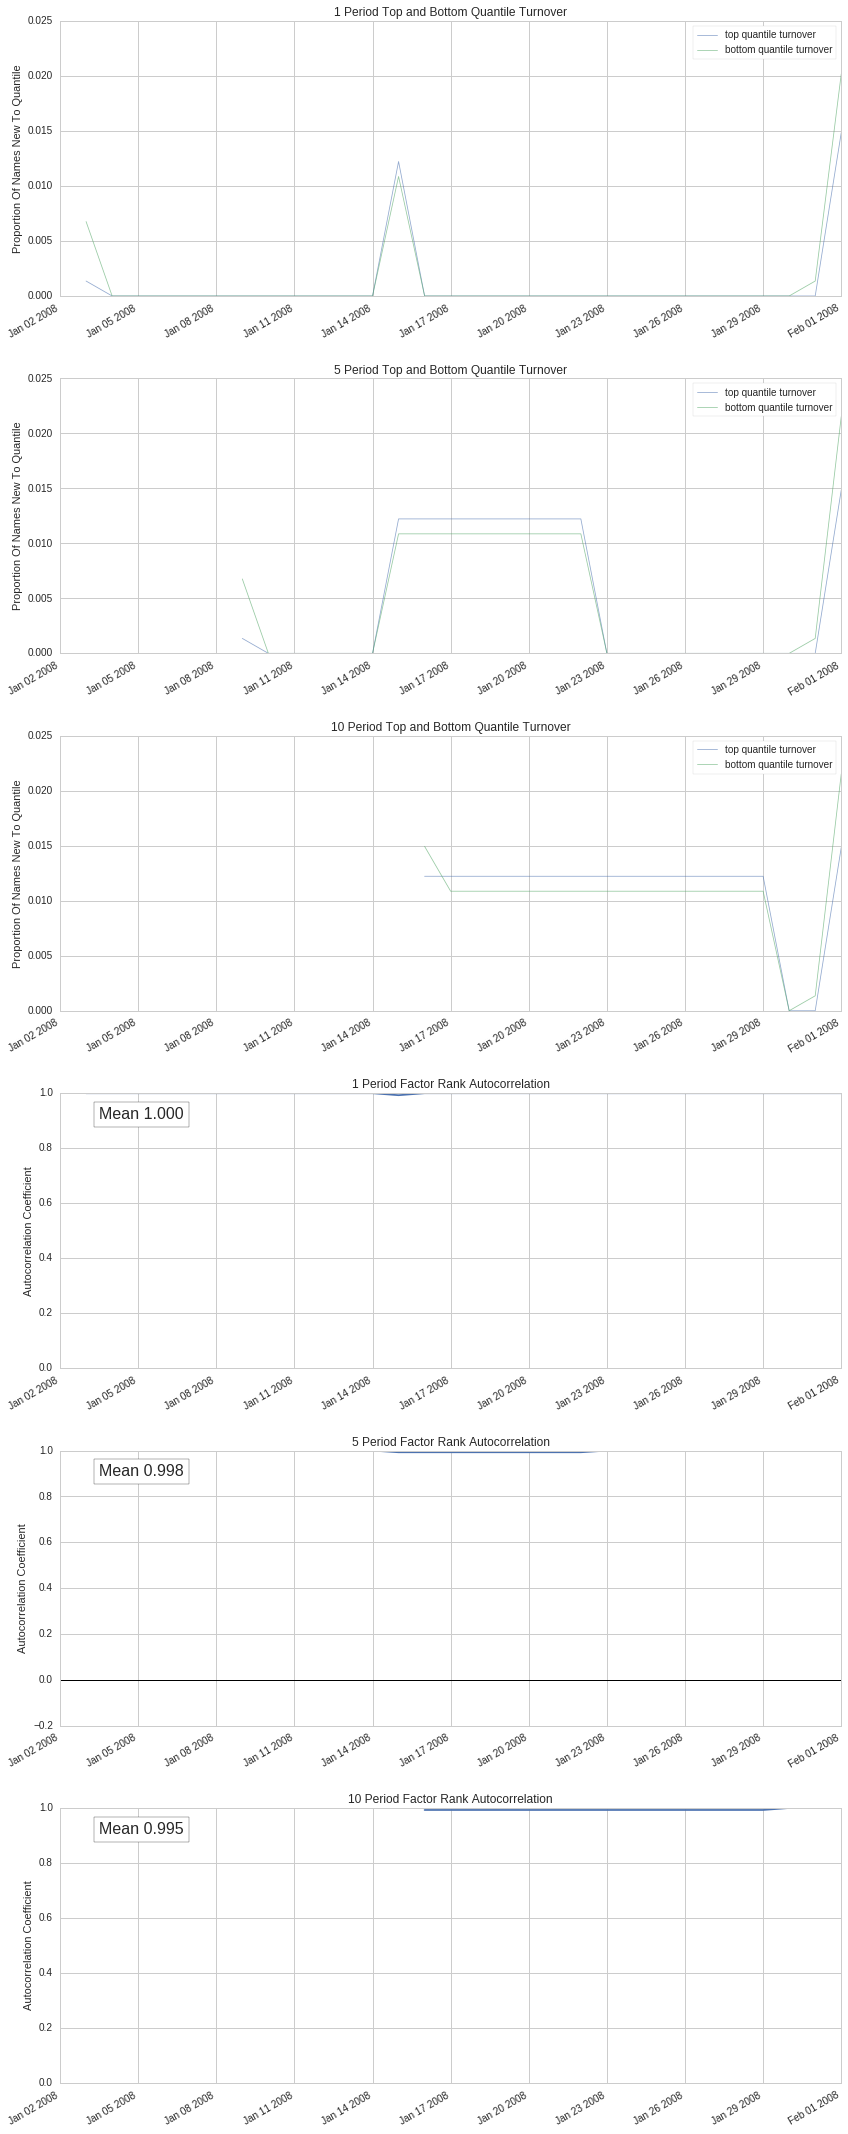

In [41]:
alphalens.tears.create_factor_tear_sheet(factor = res['testing_factor'],
                                         prices = pricing,
                                         quantiles = 2,
                                         periods = (1,5,10) )

### Visualization

The Tear Sheet created is just a sample analysis of a month because doing so for an 8 year period would take too long. But the basic objective of combining different factors to get a high alpha factor, which basically equates to a high return rate independant of how the market is doing. Note: The financial situation was pretty bad which is why the Alpha factor is negative.

Most of the visualization depict that in that month, the returns would be negative, which they were.

## Results

This is actual backtest of the algorithm which was run from 01-01-2008 to 06-01-2017
![](http://i.imgur.com/ytncH70.png)

### Analysis

We can analyze the results by creating a tear sheet of the backtested data and look into the different factors of the results generated from the simulated results. Some things to look into is the average returns every year and how it compares to the benchmark (SP500). Moreover, looking into periods of growth and decline might give some insight into when the algorithm is successful and where it requires work to be better than the benchmark. And lastly, the most significant result to look at is the overall return rate and how it compares to the benchmark. If it doesn't beat the benchmark, then the hypothesis was incorrect and Warren Buffet was right in his making his statements.

In [43]:
bt = get_backtest('59406adc6c766a69f02c2ae8')

100% Time: 0:01:07|###########################################################|


Entire data start date: 2008-01-02
Entire data end date: 2017-06-01


Backtest Months: 112


Performance statistics,Backtest
annual_return,0.06
cum_returns_final,0.71
annual_volatility,0.17
sharpe_ratio,0.42
calmar_ratio,0.14
stability_of_timeseries,0.85
max_drawdown,-0.43
omega_ratio,1.08
sortino_ratio,0.58
skew,-0.37


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,43.06,2008-06-05,2009-03-09,2011-01-12,680
1,20.30,2011-07-07,2011-10-03,2012-03-19,183
2,16.19,2015-06-23,2016-02-11,2016-08-05,294
3,9.17,2012-03-26,2012-06-04,2012-09-07,120
4,8.12,2014-07-01,2014-10-13,2015-02-05,158




[-0.021 -0.042]


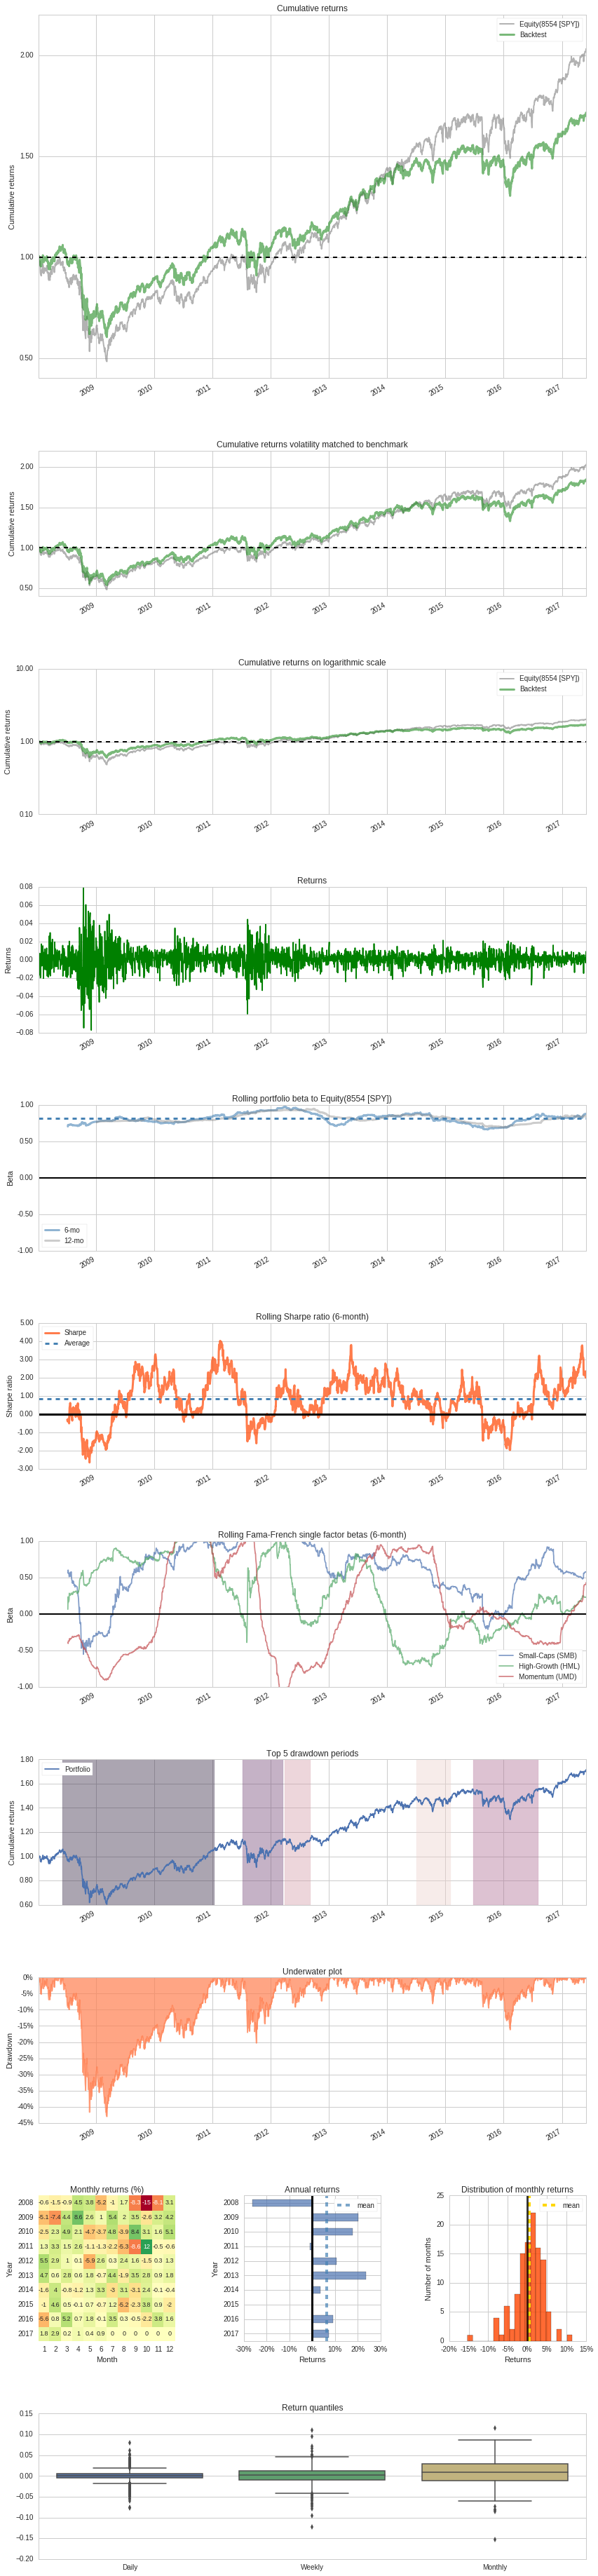

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Lehmann,-0.17%,-5.58%,3.54%
US downgrade/European Debt Crisis,-0.08%,-5.96%,4.44%
Fukushima,0.16%,-0.93%,1.48%
EZB IR Event,-0.07%,-1.07%,0.96%
Mar08,0.07%,-1.90%,2.97%
Sept08,-0.41%,-5.58%,3.54%
2009Q1,-0.31%,-4.66%,3.79%
2009Q2,0.29%,-4.24%,4.99%
Flash Crash,-0.25%,-2.34%,3.49%
Apr14,-0.05%,-1.86%,0.98%


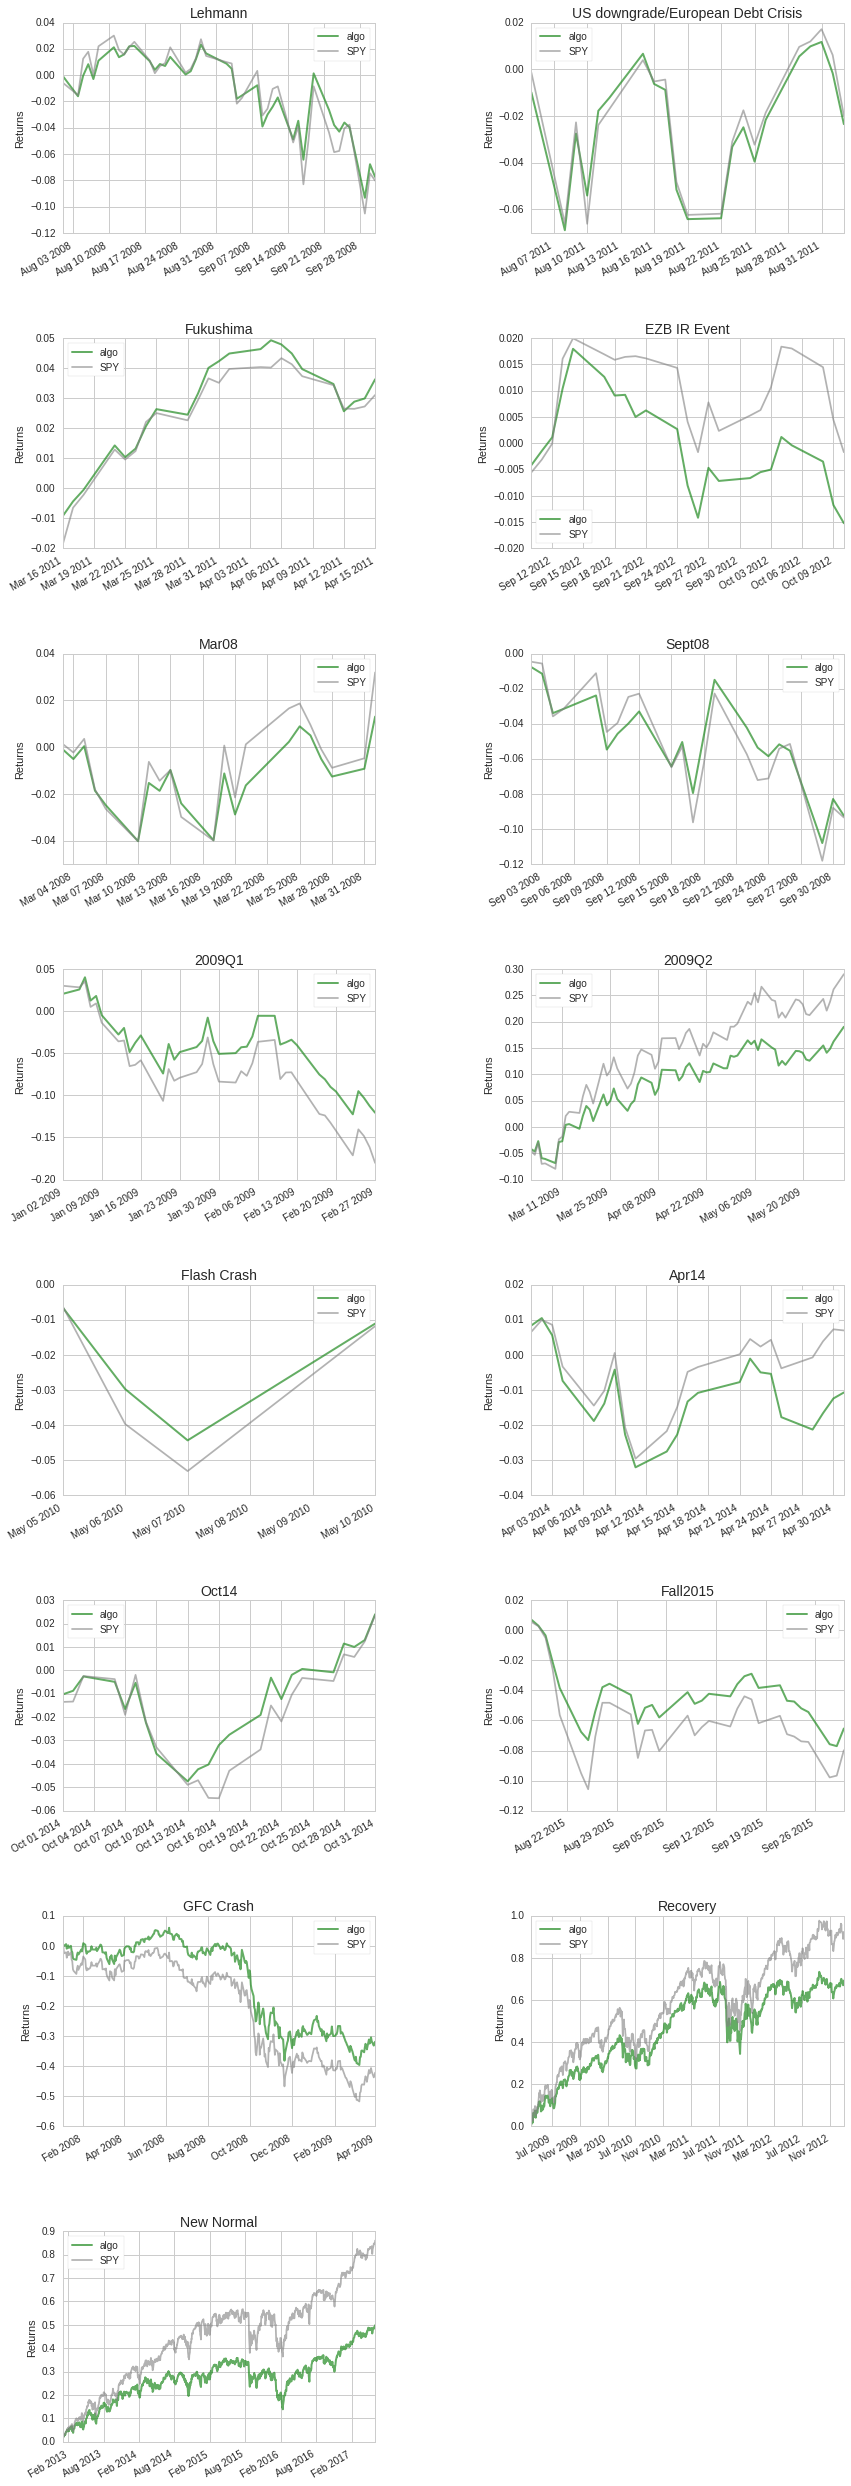

Top 10 long positions of all time,max
PCLN-19917,1.13%
AAPL-24,0.60%
CMG-28016,0.51%
BIIB-3806,0.31%
INHX-26336,0.28%
NFLX-23709,0.27%
ESI-24831,0.27%
CRM-26401,0.26%
TSLA-39840,0.26%
EQIX-24482,0.26%


Top 10 short positions of all time,max
MDVN-28160,-0.10%
DDS-2126,-0.09%
WFM-8158,-0.09%
ALNY-26335,-0.09%
SRPT-16999,-0.08%
AIG-239,-0.08%
ITMN-21284,-0.07%
SLG-17448,-0.07%
HBI-32497,-0.07%
PXD-17436,-0.07%


Top 10 positions of all time,max
PCLN-19917,1.13%
AAPL-24,0.60%
CMG-28016,0.51%
BIIB-3806,0.31%
INHX-26336,0.28%
NFLX-23709,0.27%
ESI-24831,0.27%
CRM-26401,0.26%
TSLA-39840,0.26%
EQIX-24482,0.26%


All positions ever held,max
PCLN-19917,1.13%
AAPL-24,0.60%
CMG-28016,0.51%
BIIB-3806,0.31%
INHX-26336,0.28%
NFLX-23709,0.27%
ESI-24831,0.27%
CRM-26401,0.26%
TSLA-39840,0.26%
EQIX-24482,0.26%


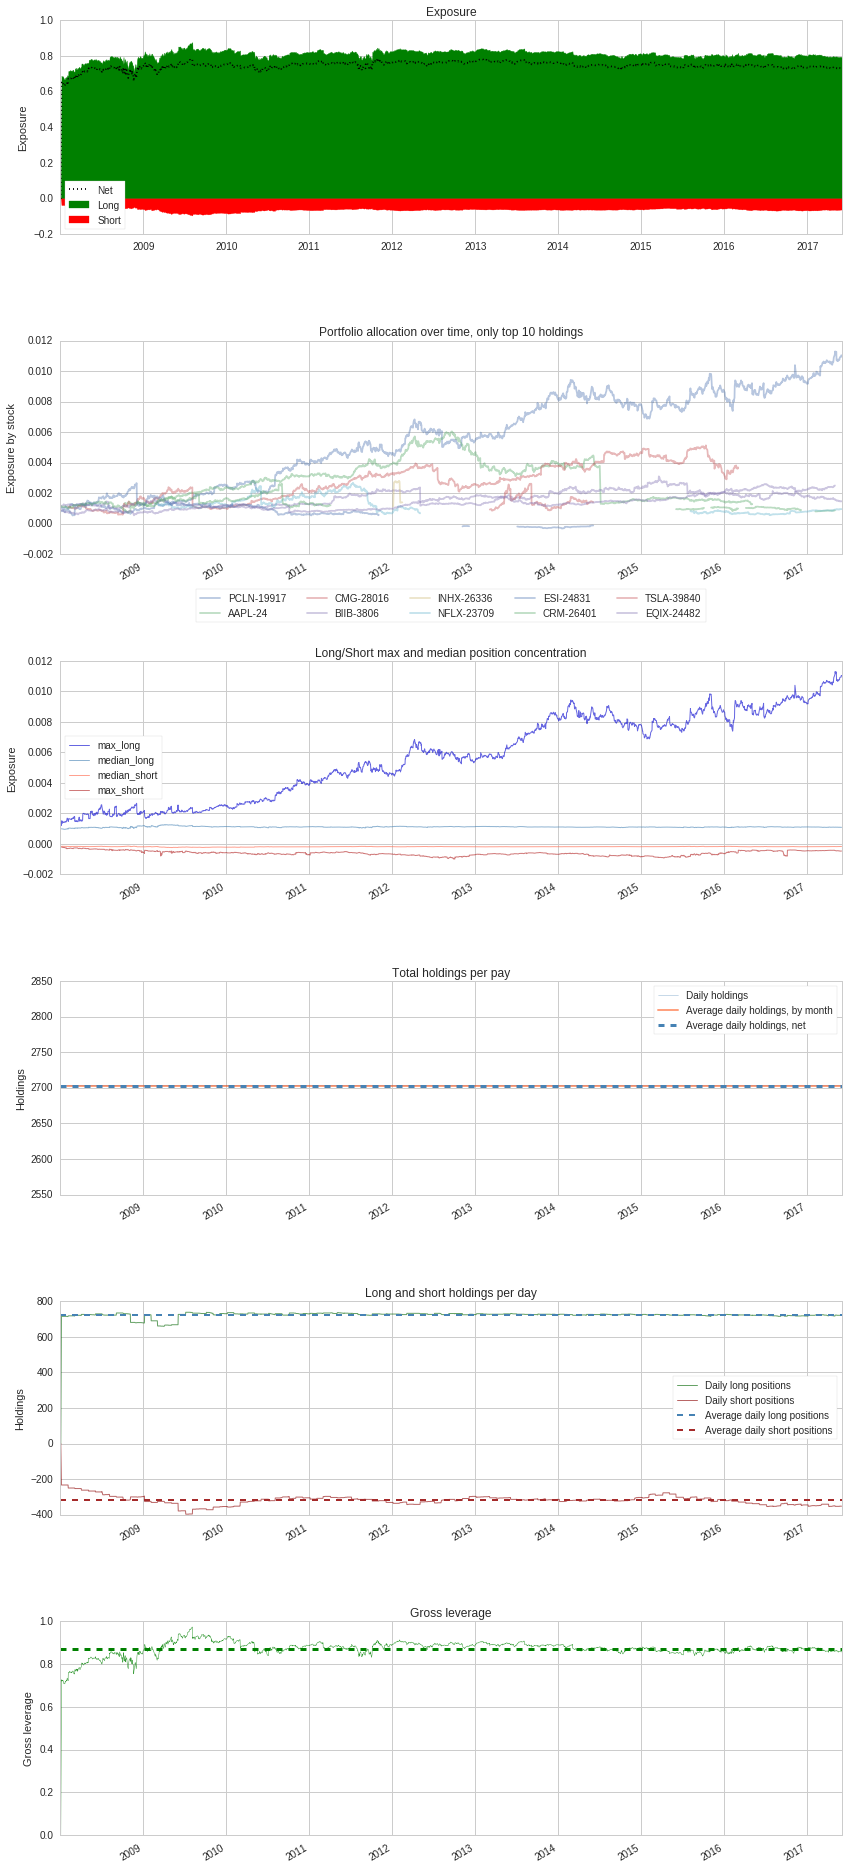

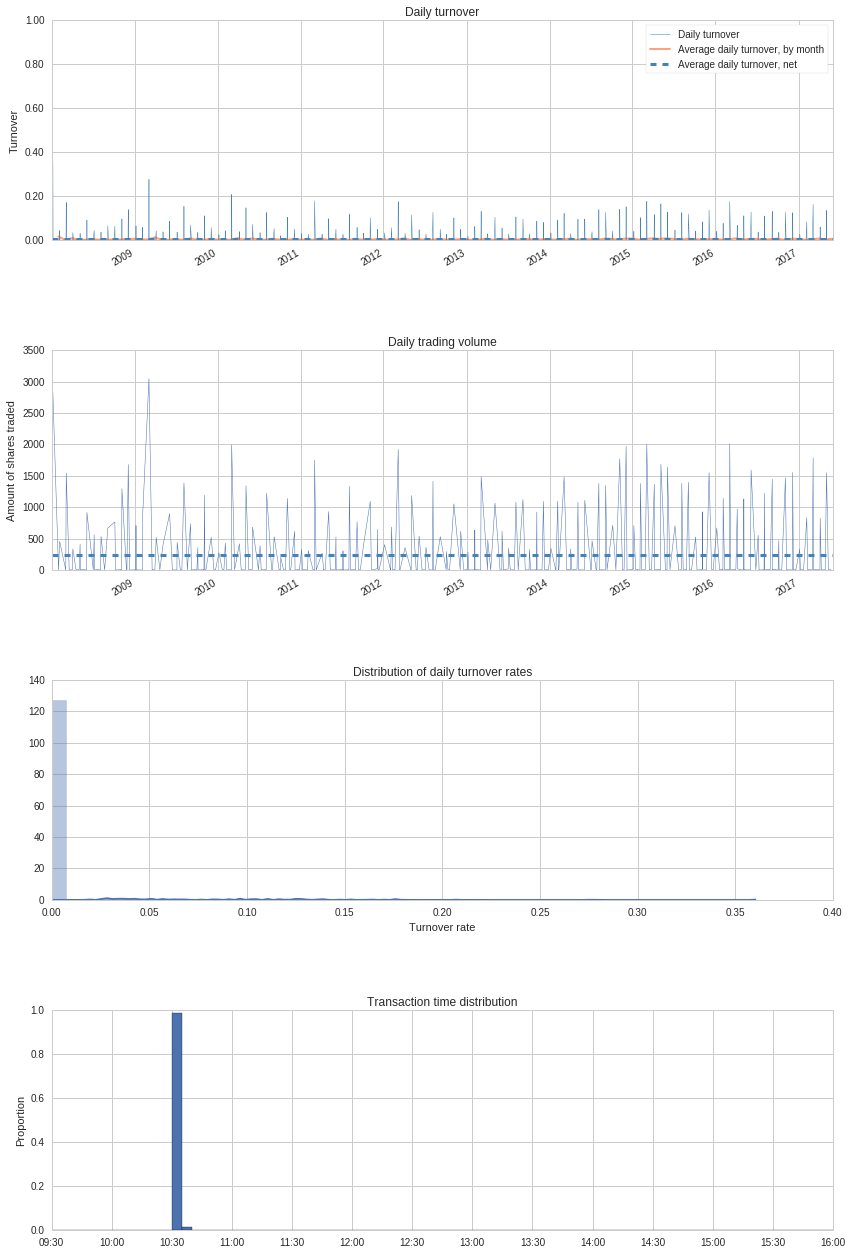

In [44]:
bt.create_full_tear_sheet()

## Discussion

### Summary

What we see is that my hypothesis was incorrect and that the SP500 is comfortably beating my portfolio. Buffet's bet was until the 31st of December, but with the current bullish market it seems unlikely that the algorithm would beat the market given it's current state.

Some noteworthy points from the graph and the tear sheet include that while the market is bearish, the algorithm seems to not perform as badly, which is probably due to the fact that a certain portion of the portfolio is shorted.

On the other hand, when the market is bullish the algorithm does grow as fast as the market during recovery period or just normal periods of good growth. This also has to do with the fact that the long leverage and short leverage are fixed.

Some other significant insights are that after the financial market crash of 2008, the SP500 doesn't make am even recovery until 2012, while the algorithm does break even in 2010 and spends the next 2 years in low growth/loss. While this might not seem significant with such a small capital it is noteworthy to point out that hedge funds that leverage borrowed money to make trades could go bankrupt, and breaking even sooner might be a valid decision where a fund might adopt a different strategy. 

Another insight from the analysis points out that the leverage never exceeds 100%, which essentially means the algorithm is only using money allocated to it and not leveraging borrowed money to make decisions.

The Final result is that over a 9.5 years period, the algorithm yielded a 71.5% growth or an 8% annual growth. While the SP500 yielded a 100.4% or a 10.5% annual growth.

### Limitations

The first and most significant limitation to the entire study and analysis is that I can never truly predict how a particular Hedge Fund operates because if I and everyone knew how to do so, there wouldn't be much of an advantage of being a fund manager and they would not make money. I can try to simulate the hedge funds by using my best guesses as to what factors they use while making these decisions but I also did not want to overcomplicate the algorithm with millions of edge cases so I made an educated guess of selecting the two most significant economic metrics of a company

Another limitation of the study is that I am merely simulating how this algorithm and portfolio would operate given past knowledge of how the market operated. The trades might not execute as fast as they do in this simulation and they might do so at higher or lower prices. This would impact the overall results of the algorithm and it might make more or less money than this time.

### Future Analysis

As seen in the summary, the rate of growth and decline seem to be proportional to how I have set up the percentage allotted to shorts and longs in the portfolio. An interesting future implementation would be to dynamically change the split based on how the market is currently doing. If the market is doing bearish, it might be wiser to short more stocks (than presently) and if it is bullish and growing significantly, the better decision might be to not short any stocks. This kind of tweaking of the portfolio might help increase the returns of the algorithm, which then might (or not) prove my original hypothesis.

Another interesting decision would be to include a very small number of stocks rather than trying to trade every single tradable stock. If I could limit just the most volatile stocks (fastest growing and declining), there might be a way to leverage shorts and longs to exponentially beat the market. However, this kind of trading cannot happen on a monthly scale as the stocks move up and down very quickly and some kind of sentiment analysis might be useful while trading these stocks every second or minute. For example one interesting analysis might be to look at President Trump's tweets and mentions of his ongoing cases and his comments on other companies and then using sentiment analysis to predict how those comments would affect the market. When President Trump tweeted about possibly cancelling Boeing's contract to build the new Air Force 1, their shares dropped 1%


### Final Remarks

After concluding this study and analysis, I would just like to mention that it was probably not the wisest decision to disprove Warren Buffet's statements as someone who is fairly new to the financial market.


### Citations

* Buffet, Warren. Berkshire’s Performance vs. the S&P 500 (n.d.): n. pag. Berkshire Hathaway. Berkshire Hathaway. Web. <http://www.berkshirehathaway.com/letters/2016ltr.pdf>.
* "Basic Usage." Quantopian Help. N.p., n.d. Web. 14 June 2017. <https://www.quantopian.com/help#quantopian_pipeline_filters_Q1500US>.
* "Basic Usage." Quantopian Help. N.p., n.d. Web. 14 June 2017. <https://www.quantopian.com/help/fundamentals#fundamentals-overview>.
* High Frequency Trading: Overview of Recent Developments (n.d.): n. pag. Web. <https://fas.org/sgp/crs/misc/R44443.pdf>.
* "Designing Nonmarket Accounts for the United States." (2003): n. pag. Web.<https://www.dol.gov/sites/default/files/ebsa/researchers/analysis/retirement/brokerageaccountsintheus.pdf>
* Baer, Justin, and Daniel Huang. "Wall Street Staffing Falls Again." The Wall Street Journal. Dow Jones & Company, 19 Feb. 2015. Web. 14 June 2017. <https://www.wsj.com/articles/wall-street-staffing-falls-for-fourth-consecutive-year-1424366858?mod=WSJ_hp_Markets3up>.


#### Appendix (Algorithm)

Note: Everything was run on Quantopian so the algorithm and notebook might needed to be run on that platform.

In [45]:
from quantopian.algorithm import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.morningstar import operation_ratios
 
def initialize(context):
    set_commission(commission.PerShare(cost=0.0, min_trade_cost=0.0))

    # Rebalance every month, 3 days into the month, 1 hour after market open.
    schedule_function(my_rebalance, date_rules.month_start(days_offset=3), time_rules.market_open(hours=1))
     
    # Record tracking variables at the end of each day.
    schedule_function(my_record_vars, date_rules.every_day(), time_rules.market_close())
     
    # Create our dynamic stock selector.
    attach_pipeline(make_pipeline(), 'my_pipeline')
         
def make_pipeline():
    # Note : operation_ratios.revenue_growth, operation_ratios.operation_margin, sentiment YES
    # Maybe test with more alpha factors
    testing_factor1 = operation_ratios.revenue_growth.latest
    testing_factor2 = operation_ratios.operation_margin.latest
    #testing_factor3 = sentiment.sentiment_signal.latest
    
    universe = ( Q1500US() & testing_factor1.notnull() &    
                testing_factor2.notnull() 
                #& testing_factor3.notnull() 
               )
    
    testing_factor1 = testing_factor1.rank(mask=universe, method='average')
    testing_factor2 = testing_factor2.rank(mask=universe, method='average')
    #testing_factor3 = testing_factor3.rank(mask=universe, method='average')
    
    testing_factor = testing_factor1 + testing_factor2 #+ testing_factor3
    testing_quantiles = testing_factor.quantiles(2)
    
    pipe = Pipeline(columns={'testing_factor': testing_factor,
                             'shorts': testing_quantiles.eq(0),
                             'longs' : testing_quantiles.eq(1)},
                             screen=universe)
    return pipe
    
 
def before_trading_start(context, data):
    context.output = pipeline_output('my_pipeline')
  
    # These are the securities that we are interested in trading each day.
    context.security_list = context.output.index
 
def my_rebalance(context,data):
    l_secs = context.output[context.output['longs']].index
    s_secs = context.output[context.output['shorts']].index
    
    l_weight =  0.85/len(l_secs)
    s_weight = -0.15/len(s_secs)
    
    for sec in l_secs:
        if data.can_trade(sec):
            order_target_percent(sec, l_weight)
    
    for sec in s_secs:
        if data.can_trade(sec):
            order_target_percent(sec, s_weight)
            
    for sec in context.portfolio.positions:
        if data.can_trade(sec) and sec not in l_secs and sec not in s_secs:
            order_target_percent(sec, 0)
 
def my_record_vars(context, data):
    l_count = 0
    s_count = 0
    
    for pos in context.portfolio.positions.itervalues():
        if pos.amount > 0:
            l_count += 1
        elif pos.amount < 0:
            s_count += 1
    
    record(l_num = l_count, s_num = s_count, leverage = context.account.leverage)

ImportError: No module named algorithm